In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization, Activation, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from skimage.io import imread
from skimage.transform import resize
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from PIL import Image
import pickle
from collections import Counter

In [2]:
data_dir = 'u_net_data'
image_dir = os.path.join(data_dir, 'images')
mask_dir = os.path.join(data_dir, 'masks')
pickle_dir = os.path.join(data_dir, 'mask_pickle')

In [3]:
img_height, img_width = 512, 512

In [4]:
first_n = 300
image_list = os.listdir(image_dir)
if '.ipynb_checkpoints' in image_list:
    image_list.remove('.ipynb_checkpoints')
    image_list = image_list#[:first_n]
mask_list = os.listdir(mask_dir)#[:first_n]
pickle_list = os.listdir(pickle_dir)#[:first_n]
print(f'number of samples {len(image_list)}')
print(f'number of samples {len(pickle_list)}')

number of samples 1342
number of samples 1342


In [5]:
# globus might augment the images
# when I plot the individuals  
# try a different image type
# 

X = np.zeros((len(image_list), img_height, img_width, 3), dtype=np.float32)
y = np.zeros((len(mask_list), img_height, img_width, 1), dtype=np.float32)
remove = []
for i, (image, mask) in tqdm(enumerate(zip(image_list, mask_list))):
    try:
        pickle_name = os.path.join(pickle_dir, mask.split('.')[0] + '.pickle')
        with open(pickle_name, "rb") as file:
            mask = pickle.load(file)
        if (np.sum(mask)/255 < 318) or (np.sum(mask)/255 > 11121):
            remove.append(i)
        if len(np.unique(mask)) != 2: # data quality
            remove.append(i)
        y[i] = mask.reshape(img_height, img_width, 1)/255
        img = imread(os.path.join(image_dir, image))
        X[i] = img / 255
    except:
        remove.append(i)
        continue
        
# add bad masks here manually
# bad_mask_index = [998, 878]
# remove = remove + bad_mask_index
X = np.delete(X, remove, axis=0)
y = np.delete(y, remove, axis=0)
y = y.astype(int)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

1342it [00:13, 98.96it/s] 


In [6]:
print("Shape of X_train:", X_train.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_val:", y_val.shape)
print("\nShape of all data:", X.shape)

Shape of X_train: (1081, 512, 512, 3)
Shape of X_val: (121, 512, 512, 3)
Shape of y_train: (1081, 512, 512, 1)
Shape of y_val: (121, 512, 512, 1)

Shape of all data: (1202, 512, 512, 3)


In [7]:
min_value = np.min(X)
max_value = np.max(X)

print("minimum pixel value:", min_value)
print("maximum pixel value:", max_value)

minimum pixel value: 0.0
maximum pixel value: 1.0


In [8]:
print(f"unique values of y: {np.unique(y)}")

unique values of y: [0 1]


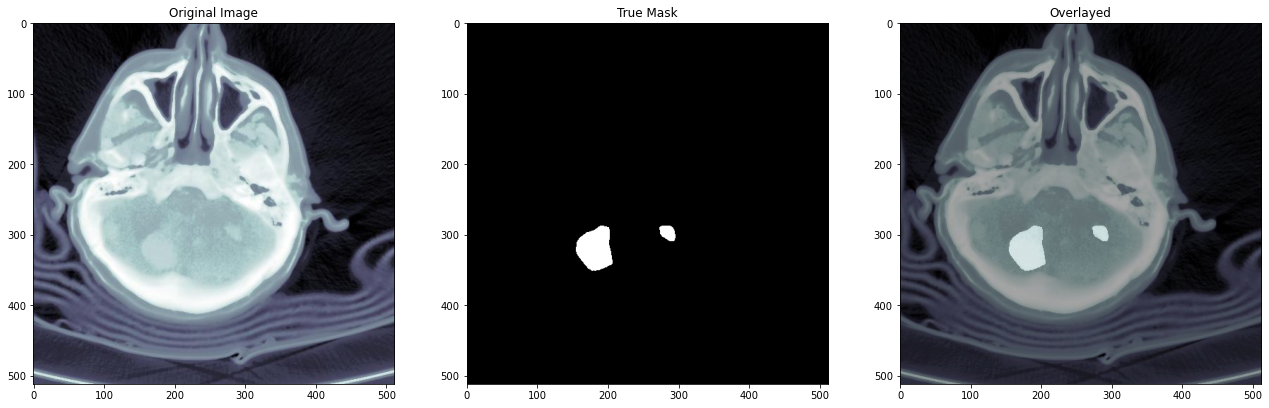

In [9]:
index = np.random.randint(len(X_train))
image = X_train[index]
true_mask = y_train[index]

fig, axes = plt.subplots(1, 3, figsize=(22, 7))

axes[0].imshow(image)
axes[0].set_title("Original Image")

axes[1].imshow(true_mask.squeeze(), cmap='gray')
axes[1].set_title("True Mask")

axes[2].imshow(image)
axes[2].imshow(true_mask.squeeze(), cmap='gray', alpha=0.35)
axes[2].set_title("Overlayed")

plt.show()

In [10]:
def conv_block(inputs, filters, bn = True):
    conv = Conv2D(filters, (3, 3), padding='same')(inputs)
    if bn:
        conv = BatchNormalization()(conv)
    conv = Activation('relu')(conv)
    conv = Conv2D(filters, (3, 3), padding='same')(conv)
    if bn:
        conv = BatchNormalization()(conv)
    conv = Activation('relu')(conv)
    return conv

def unet(input_size=(img_height, img_width, 3), num_filters=16):
    inputs = Input(input_size)

    c1 = conv_block(inputs, num_filters)
    p1 = MaxPooling2D(pool_size=(2, 2))(c1)

    c2 = conv_block(p1, num_filters*2)
    p2 = MaxPooling2D(pool_size=(2, 2))(c2)

    c3 = conv_block(p2, num_filters*4)
    p3 = MaxPooling2D(pool_size=(2, 2))(c3)

    c4 = conv_block(p3, num_filters*8)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = conv_block(p4, num_filters*16)

    u6 = UpSampling2D(size=(2, 2))(c5)
    u6 = concatenate([u6, c4])
    c6 = conv_block(u6, num_filters*8)

    u7 = UpSampling2D(size=(2, 2))(c6)
    u7 = concatenate([u7, c3])
    c7 = conv_block(u7, num_filters*4)

    u8 = UpSampling2D(size=(2, 2))(c7)
    u8 = concatenate([u8, c2])
    c8 = conv_block(u8, num_filters*2)

    u9 = UpSampling2D(size=(2, 2))(c8)
    u9 = concatenate([u9, c1])
    c9 = conv_block(u9, num_filters)

    outputs = Conv2D(1, (1, 1), activation='relu')(c9)

    return Model(inputs=inputs, outputs=outputs)

In [11]:
model = unet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 512, 512, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 512, 512, 16) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [12]:
# add one more layer -> segmentation output

from tensorflow.keras.metrics import Recall
from tensorflow.keras import backend as K

In [13]:
def IOU(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    
    intersection = K.sum(y_true_f * y_pred_f)
    
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    
    iou = (intersection + smooth) / (union + smooth)
    
    return iou

In [ ]:
def jaccard_index(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    
    

In [14]:
model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=[IOU])
# model.compile(optimizer=Adam(lr=1e-5), loss='binary_crossentropy', metrics=[Recall()])

checkpoint = ModelCheckpoint('unet_weights.h5', monitor='val_loss', save_best_only=True)

epochs = 20
batch_size = 12

history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, callbacks=[checkpoint], validation_data=(X_val, y_val))

Epoch 1/20
91/91 [==============================] - 51s 555ms/step - loss: 1.9500 - IOU: 0.0057 - val_loss: 0.1311 - val_IOU: 0.0107
Epoch 2/20
91/91 [==============================] - 49s 540ms/step - loss: 0.3344 - IOU: 0.0074 - val_loss: 0.0820 - val_IOU: 0.0114
Epoch 3/20
91/91 [==============================] - 50s 544ms/step - loss: 0.1815 - IOU: 0.0094 - val_loss: 0.1118 - val_IOU: 0.0032
Epoch 4/20
91/91 [==============================] - 50s 548ms/step - loss: 0.1160 - IOU: 0.0120 - val_loss: 0.0923 - val_IOU: 0.0097
Epoch 5/20
91/91 [==============================] - 50s 548ms/step - loss: 0.0964 - IOU: 0.0123 - val_loss: 0.0713 - val_IOU: 0.0238
Epoch 6/20
91/91 [==============================] - 50s 544ms/step - loss: 0.0870 - IOU: 0.0126 - val_loss: 0.0840 - val_IOU: 0.0195
Epoch 7/20
91/91 [==============================] - 50s 544ms/step - loss: 0.1186 - IOU: 0.0068 - val_loss: 0.0732 - val_IOU: 0.0161
Epoch 8/20
91/91 [==============================] - 50s 546ms/step - 

In [44]:
def jaccard_loss(y_true, y_pred):
    intersection = y_true*y_pred
    union = 1 -((1-y_true)*(1-y_pred))
    return 1-(K.sum(intersection) / K.sum(union))

def unet(pretrained_weights = None,input_size = (128,128,1),learningRate=1e-5,decayRate=1e-7):
    ModInputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(ModInputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9) #sigmoid

    model = Model(inputs = ModInputs, outputs = conv10)

    model.compile(optimizer = Adam(lr = learningRate,decay=decayRate), loss = 'binary_crossentropy', metrics=['accuracy', jaccard_loss])
    

    if(pretrained_weights):
        model.load_weights(pretrained_weights)

    return model

In [ ]:
# incompatible size
model = unet()
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, callbacks=[checkpoint], validation_data=(X_val, y_val))

In [25]:
def IOU_nonK(y_true, y_pred, smooth=1):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    
    intersection = np.sum(y_true_f * y_pred_f)
    
    union = np.sum(y_true_f) + np.sum(y_pred_f) - intersection
    
    iou = (intersection + smooth) / (union + smooth)
    
    return iou

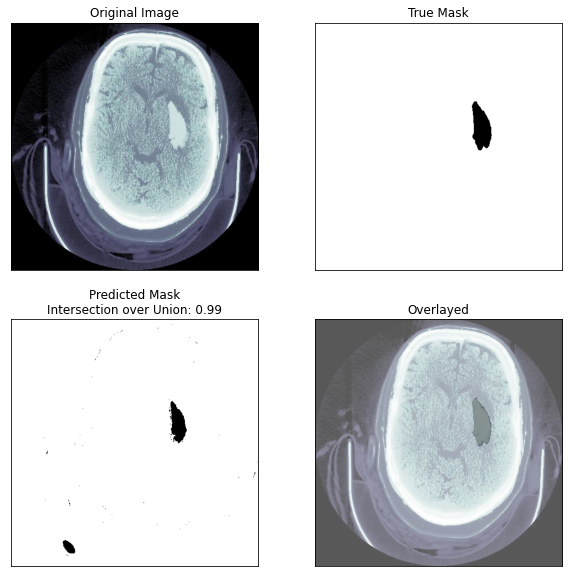

In [41]:
index = np.random.randint(len(X_val))
image = X_val[index]
true_mask = np.where(np.abs(y_val[index]), 0, 1)
predicted_mask = model.predict(np.expand_dims(image, axis=0))[0]
predicted_mask = (predicted_mask < 0.2).astype(np.uint8)
# pixel_accuracy = (predicted_mask == true_mask).mean()
iou = IOU_nonK(true_mask, predicted_mask)

fig, axes = plt.subplots(2, 2, figsize=(10, 10))

axes[0, 0].imshow(image)
axes[0, 0].set_title("Original Image")

axes[0, 1].imshow(true_mask.squeeze(), cmap='gray')
axes[0, 1].set_title("True Mask")

axes[1, 0].imshow(predicted_mask.squeeze(), cmap='gray')
axes[1, 0].set_title("Predicted Mask\nIntersection over Union: {:.2f}".format((iou)))

axes[1, 1].imshow(image)
axes[1, 1].imshow(true_mask.squeeze(), cmap='gray', alpha=0.35)
axes[1, 1].set_title("Overlayed")

for ax in axes.flat:
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()